**Celda 1:** Verificación de Estructura de Carpetas

**Descripción:** Este código recorre y muestra la estructura de directorios bajo la ruta especificada, imprimiendo la ubicación de cada archivo. Esto es útil para verificar que los archivos de datos estén en las ubicaciones esperadas antes de proceder a cargarlos.

In [1]:
import os
# Itera sobre todos los archivos en el directorio especificado y sus subdirectorios.
for dirname, _, filenames in os.walk('./kaggle/input/nlp-getting-started'):
    # Para cada archivo encontrado, imprime la ruta completa.
    for filename in filenames:
        print(os.path.join(dirname, filename))

./kaggle/input/nlp-getting-started\sample_submission.csv
./kaggle/input/nlp-getting-started\test.csv
./kaggle/input/nlp-getting-started\train.csv


**Celda 2:** Instalación de Paquetes

**Descripción:** Instalación de librerías necesarias para el análisis de datos, visualización, y modelado. Este paso asegura que todas las dependencias requeridas estén disponibles en el entorno de ejecución.

In [2]:
# Se instalan todos los paquetes necesarios.
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install missingno
!pip install wordcloud
!pip install tokenization
!pip install geopy
!pip install folium
!pip install nltk
!pip install scikit-learn
!pip install xgboost

**Celda 3:** Importación de Librerías

**Descripción:** Importa las librerías necesarias para manejar datos, realizar cálculos numéricos, visualizar datos, y procesar texto.

In [3]:
# Se importan todas las librerías necesarias.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from wordcloud import WordCloud
import gc
import re
import string
import operator
from collections import defaultdict
import tokenization
from wordcloud import STOPWORDS

**Celda 4:** Carga de Datos

**Descripción:** Carga los conjuntos de datos de entrenamiento y prueba desde sus respectivas ubicaciones en disco. Estos datos son esenciales para el entrenamiento y evaluación de modelos de machine learning.

In [4]:
# Carga el conjunto de datos de entrenamiento desde el archivo train.csv
train = pd.read_csv('./kaggle/input/nlp-getting-started/train.csv')
# Carga el conjunto de datos de prueba desde el archivo test.csv.
test=  pd.read_csv('./kaggle/input/nlp-getting-started/test.csv')

**Celda 5:** Visualización Preliminar de los Datos

**Descripción:** Muestra las primeras cinco filas del conjunto de datos de entrenamiento para obtener una vista preliminar de la estructura de los datos, incluyendo columnas y valores típicos.

In [5]:
# Muestra las primeras cinco filas del conjunto de datos de entrenamiento.
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


**Celda 6:** Visualización de Valores Faltantes

**Descripción:** Esta celda genera un mapa de calor que muestra dónde faltan valores en el conjunto de datos de entrenamiento. Los valores faltantes se visualizan en un color diferente, lo que facilita la identificación visual de patrones de datos faltantes. La visualización ayuda a decidir si se necesitan pasos adicionales para la imputación o eliminación de datos faltantes.

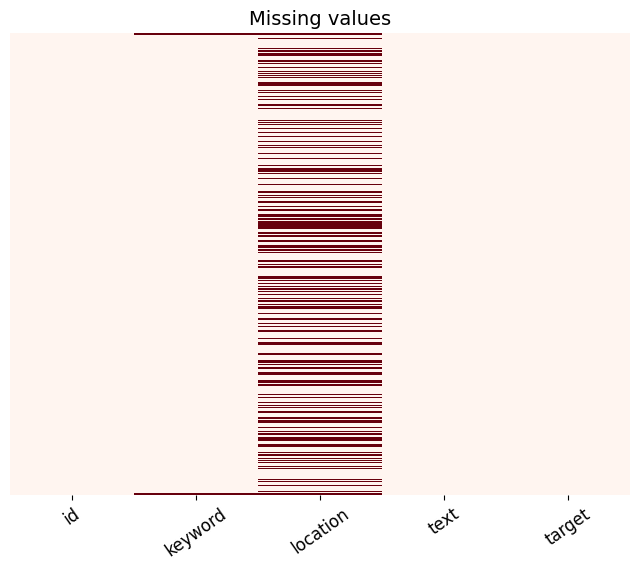

In [6]:
# Configura el tamaño de la figura para la visualización.
plt.figure(figsize = (8, 6))
# Crea un mapa de calor para visualizar los valores faltantes en el DataFrame.
sns.heatmap(train.isna(), yticklabels = False, cbar = False, cmap = 'Reds')
# Configura el título y el tamaño de la fuente para el título del gráfico.
plt.title("Missing values", fontsize = 14)
# Configura la rotación y el tamaño de la fuente para las etiquetas del eje x.
plt.xticks(rotation = 35, fontsize = 12)
# Muestra la figura.
plt.show()

**Celda 7:** Distribución de la Variable Objetivo

**Descripción:** Muestra la distribución de la variable objetivo ('target') en el conjunto de datos de entrenamiento tanto en forma de gráfico de pastel como de barras. Esto es crucial para entender el balance entre clases en datos de clasificación, lo que puede influir en la selección del modelo y la evaluación de su rendimiento.

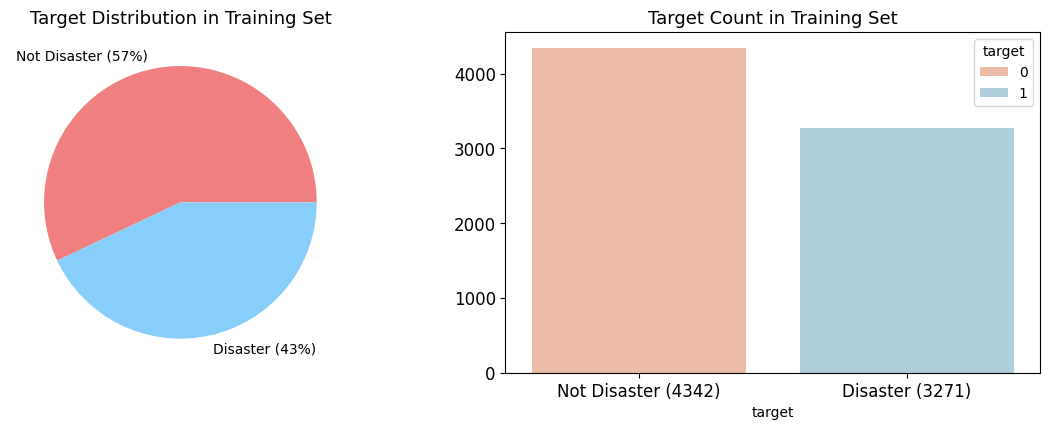

In [7]:
# Configura una figura con dos subplots (gráficos).
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
# Ajusta el layout para evitar superposiciones.
plt.tight_layout()

# Genera un gráfico de pastel para mostrar la distribución de la variable objetivo.
train.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'],colors=['lightcoral','lightskyblue'])
# Genera un gráfico de barras para mostrar la distribución de la variable objetivo.
sns.countplot(x=train['target'], hue=train['target'], ax=axes[1], palette="RdBu")

axes[0].set_ylabel('') # Elimina la etiqueta del eje y para el gráfico de pastel.
axes[1].set_ylabel('') # Elimina la etiqueta del eje y para el gráfico de barras.
axes[1].set_xticks([0, 1]) # Establece los ticks del eje x para el gráfico de barras.
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)']) # Etiquetas personalizadas para los ticks del eje x.
axes[0].tick_params(axis='x', labelsize=12) # Ajusta el tamaño de la fuente para las etiquetas del eje x del gráfico de pastel
axes[0].tick_params(axis='y', labelsize=12) # Ajusta el tamaño de la fuente para las etiquetas del eje y del gráfico de pastel
axes[1].tick_params(axis='x', labelsize=12) # Ajusta el tamaño de la fuente para las etiquetas del eje x del gráfico de barras.
axes[1].tick_params(axis='y', labelsize=12) # Ajusta el tamaño de la fuente para las etiquetas del eje y del gráfico de barras.

axes[0].set_title('Target Distribution in Training Set', fontsize=13) # Título para el gráfico de pastel.
axes[1].set_title('Target Count in Training Set', fontsize=13) # Título para el gráfico de barras.

# Muestra los gráficos.
plt.show()

**Celda 8:** Conteo de Localizaciones

**Descripción:** Visualiza las diez localizaciones más frecuentes en el conjunto de datos, proporcionando un gráfico de barras para evaluar dónde se generan más tweets. Esto puede ser útil para análisis geográficos adicionales o para entender mejor el contexto de los datos.

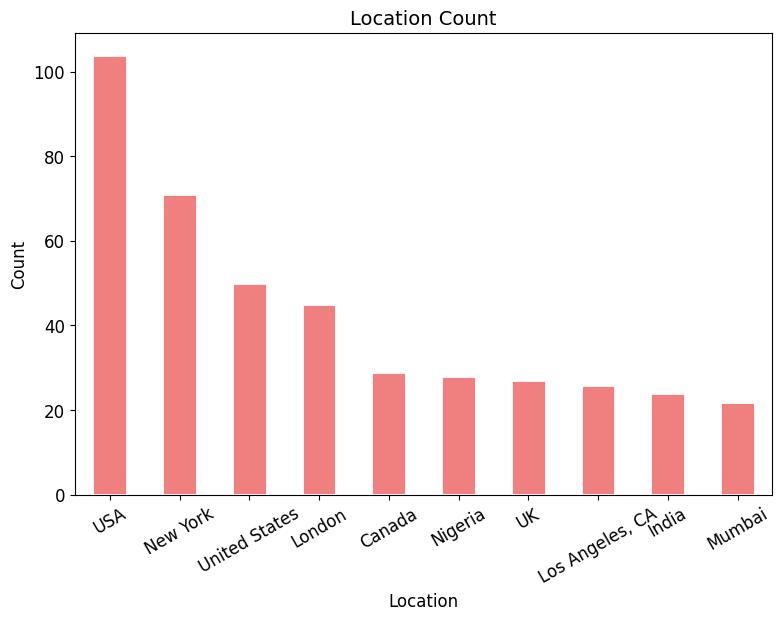

In [8]:
# Configura el tamaño de la figura para la visualización.
plt.figure(figsize = (9, 6))
# Crea un objeto de ejes para el gráfico.
ax = plt.axes()
# Establece el color de fondo del área de los ejes.
ax.set_facecolor('white')

# Genera un gráfico de barras de las 10 localizaciones más frecuentes.
ax = ((train.location.value_counts())[:10]).plot(kind = 'bar', color = 'lightcoral', linewidth = 2, edgecolor = 'white')

# Configura el título y las etiquetas de los ejes con sus respectivos tamaños de fuente.
plt.title('Location Count', fontsize = 14)
plt.xlabel('Location', fontsize = 12)
plt.ylabel('Count', fontsize = 12)

# Ajusta las propiedades de las etiquetas de los ejes.
ax.xaxis.set_tick_params(labelsize = 12, rotation = 30)
ax.yaxis.set_tick_params(labelsize = 12)

**Celda 9:** Generación de N-Gramas

**Descripción:** Define una función para generar n-gramas de palabras de los tweets y luego calcula y almacena las frecuencias de unigramas, bigramas y trigramas para tweets clasificados como desastres y no desastres. Esta información es vital para entender las diferencias en el uso del lenguaje entre diferentes tipos de tweets, lo que puede ser crucial para la caracterización y clasificación.

In [9]:
# Definición de la función que genera n-gramas.
def generate_ngrams(text, n_gram=1):
    # Divide el texto en tokens, omite tokens vacíos y stopwords.
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    # Genera los n-gramas.
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

# Frecuencia de unigramas, bigramas y trigramas para tweets de desastre y no desastre.
N = 50
DISASTER_TWEETS = train['target'] == 1 # Filtra tweets etiquetados como desastres.

# Unigramas.
# Diccionarios para almacenar la frecuencia de los n-gramas.
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

# Conteo de unigramas en tweets de desastres y no desastres.
for tweet in train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
for tweet in train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1

# Conversión de los resultados a DataFrame para visualización
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigramas.
# Diccionarios para almacenar la frecuencia de los n-gramas.
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

# Conteo de bigramas en tweets de desastres y no desastres.
for tweet in train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1

# Conversión de los resultados a DataFrame para visualización
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigramas.
# Diccionarios para almacenar la frecuencia de los n-gramas.
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

# Conteo de trigramas en tweets de desastres y no desastres
for tweet in train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1

# Conversión de los resultados a DataFrame para visualización
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

**Celda 10:** Visualización de Unigramas

**Descripción:** Esta celda visualiza los N unigramas más comunes en tweets catalogados como desastres y no desastres. Se utilizan dos gráficos de barras horizontales para mostrar claramente las diferencias en el uso de palabras frecuentes entre los dos tipos de tweets, lo que puede ofrecer insights importantes para la creación de características o la interpretación de los modelos de clasificación.

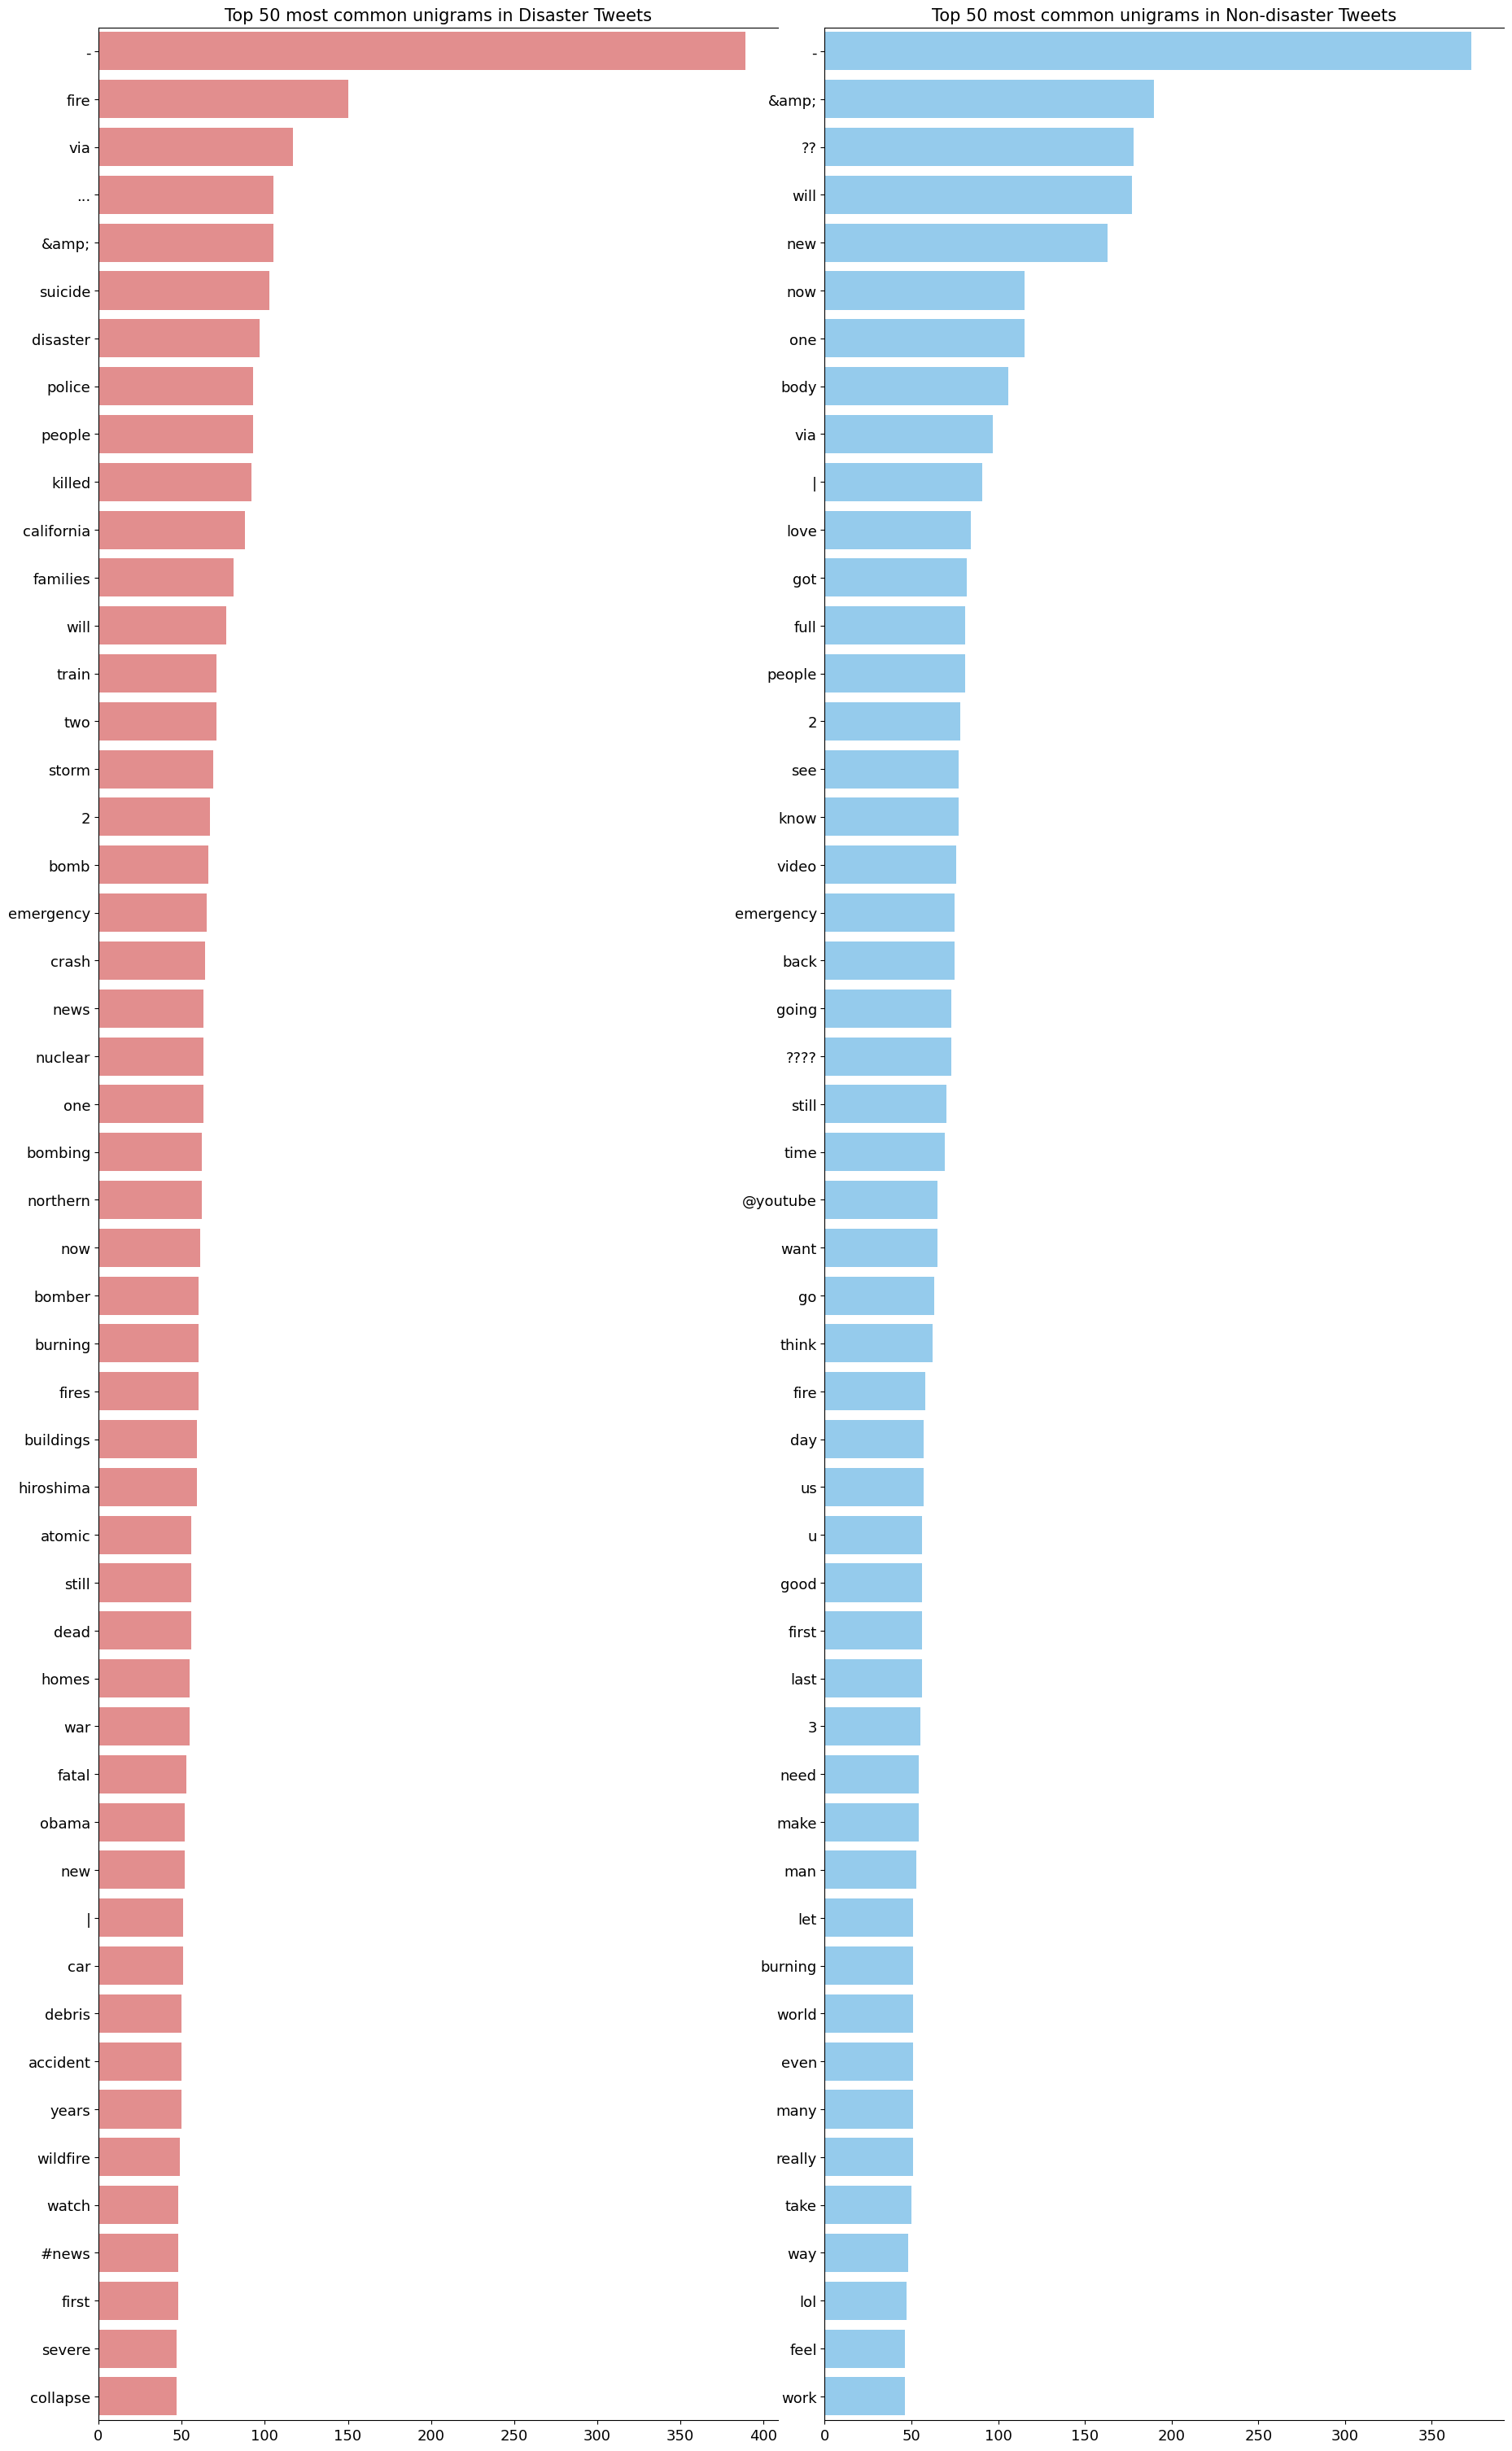

In [10]:
# Configura una figura con dos subplots (gráficos) para las visualizaciones.
fig, axes = plt.subplots(ncols=2, figsize=(18, 30), dpi=100)
# Ajusta el layout para evitar superposiciones.
plt.tight_layout()

# Genera un gráfico de barras horizontales para los unigramas más comunes en tweets de desastres.
sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='lightcoral')
# Genera un gráfico de barras horizontales para los unigramas más comunes en tweets no desastres.
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='lightskyblue')

# Configura la visualización de los ejes y etiquetas.
for i in range(2):
    axes[i].spines['right'].set_visible(False) # Oculta el borde derecho para mejorar la estética.
    axes[i].set_xlabel('') # Elimina la etiqueta del eje x.
    axes[i].set_ylabel('') # Elimina la etiqueta del eje y.
    axes[i].tick_params(axis='x', labelsize=13) # Configura el tamaño de la etiqueta para el eje x.
    axes[i].tick_params(axis='y', labelsize=13) # Configura el tamaño de la etiqueta para el eje y.

# Configura los títulos de los gráficos.
axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

# Muestra los gráficos.
plt.show()

**Celda 11:** Visualización de Bigramas

**Descripción:** Similar a la visualización de unigramas, esta celda muestra los bigramas más comunes en tweets de desastres y no desastres. Estos insights ayudan a comprender las combinaciones de palabras comunes y cómo difieren en contextos de desastre.

C:\Users\rgall\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


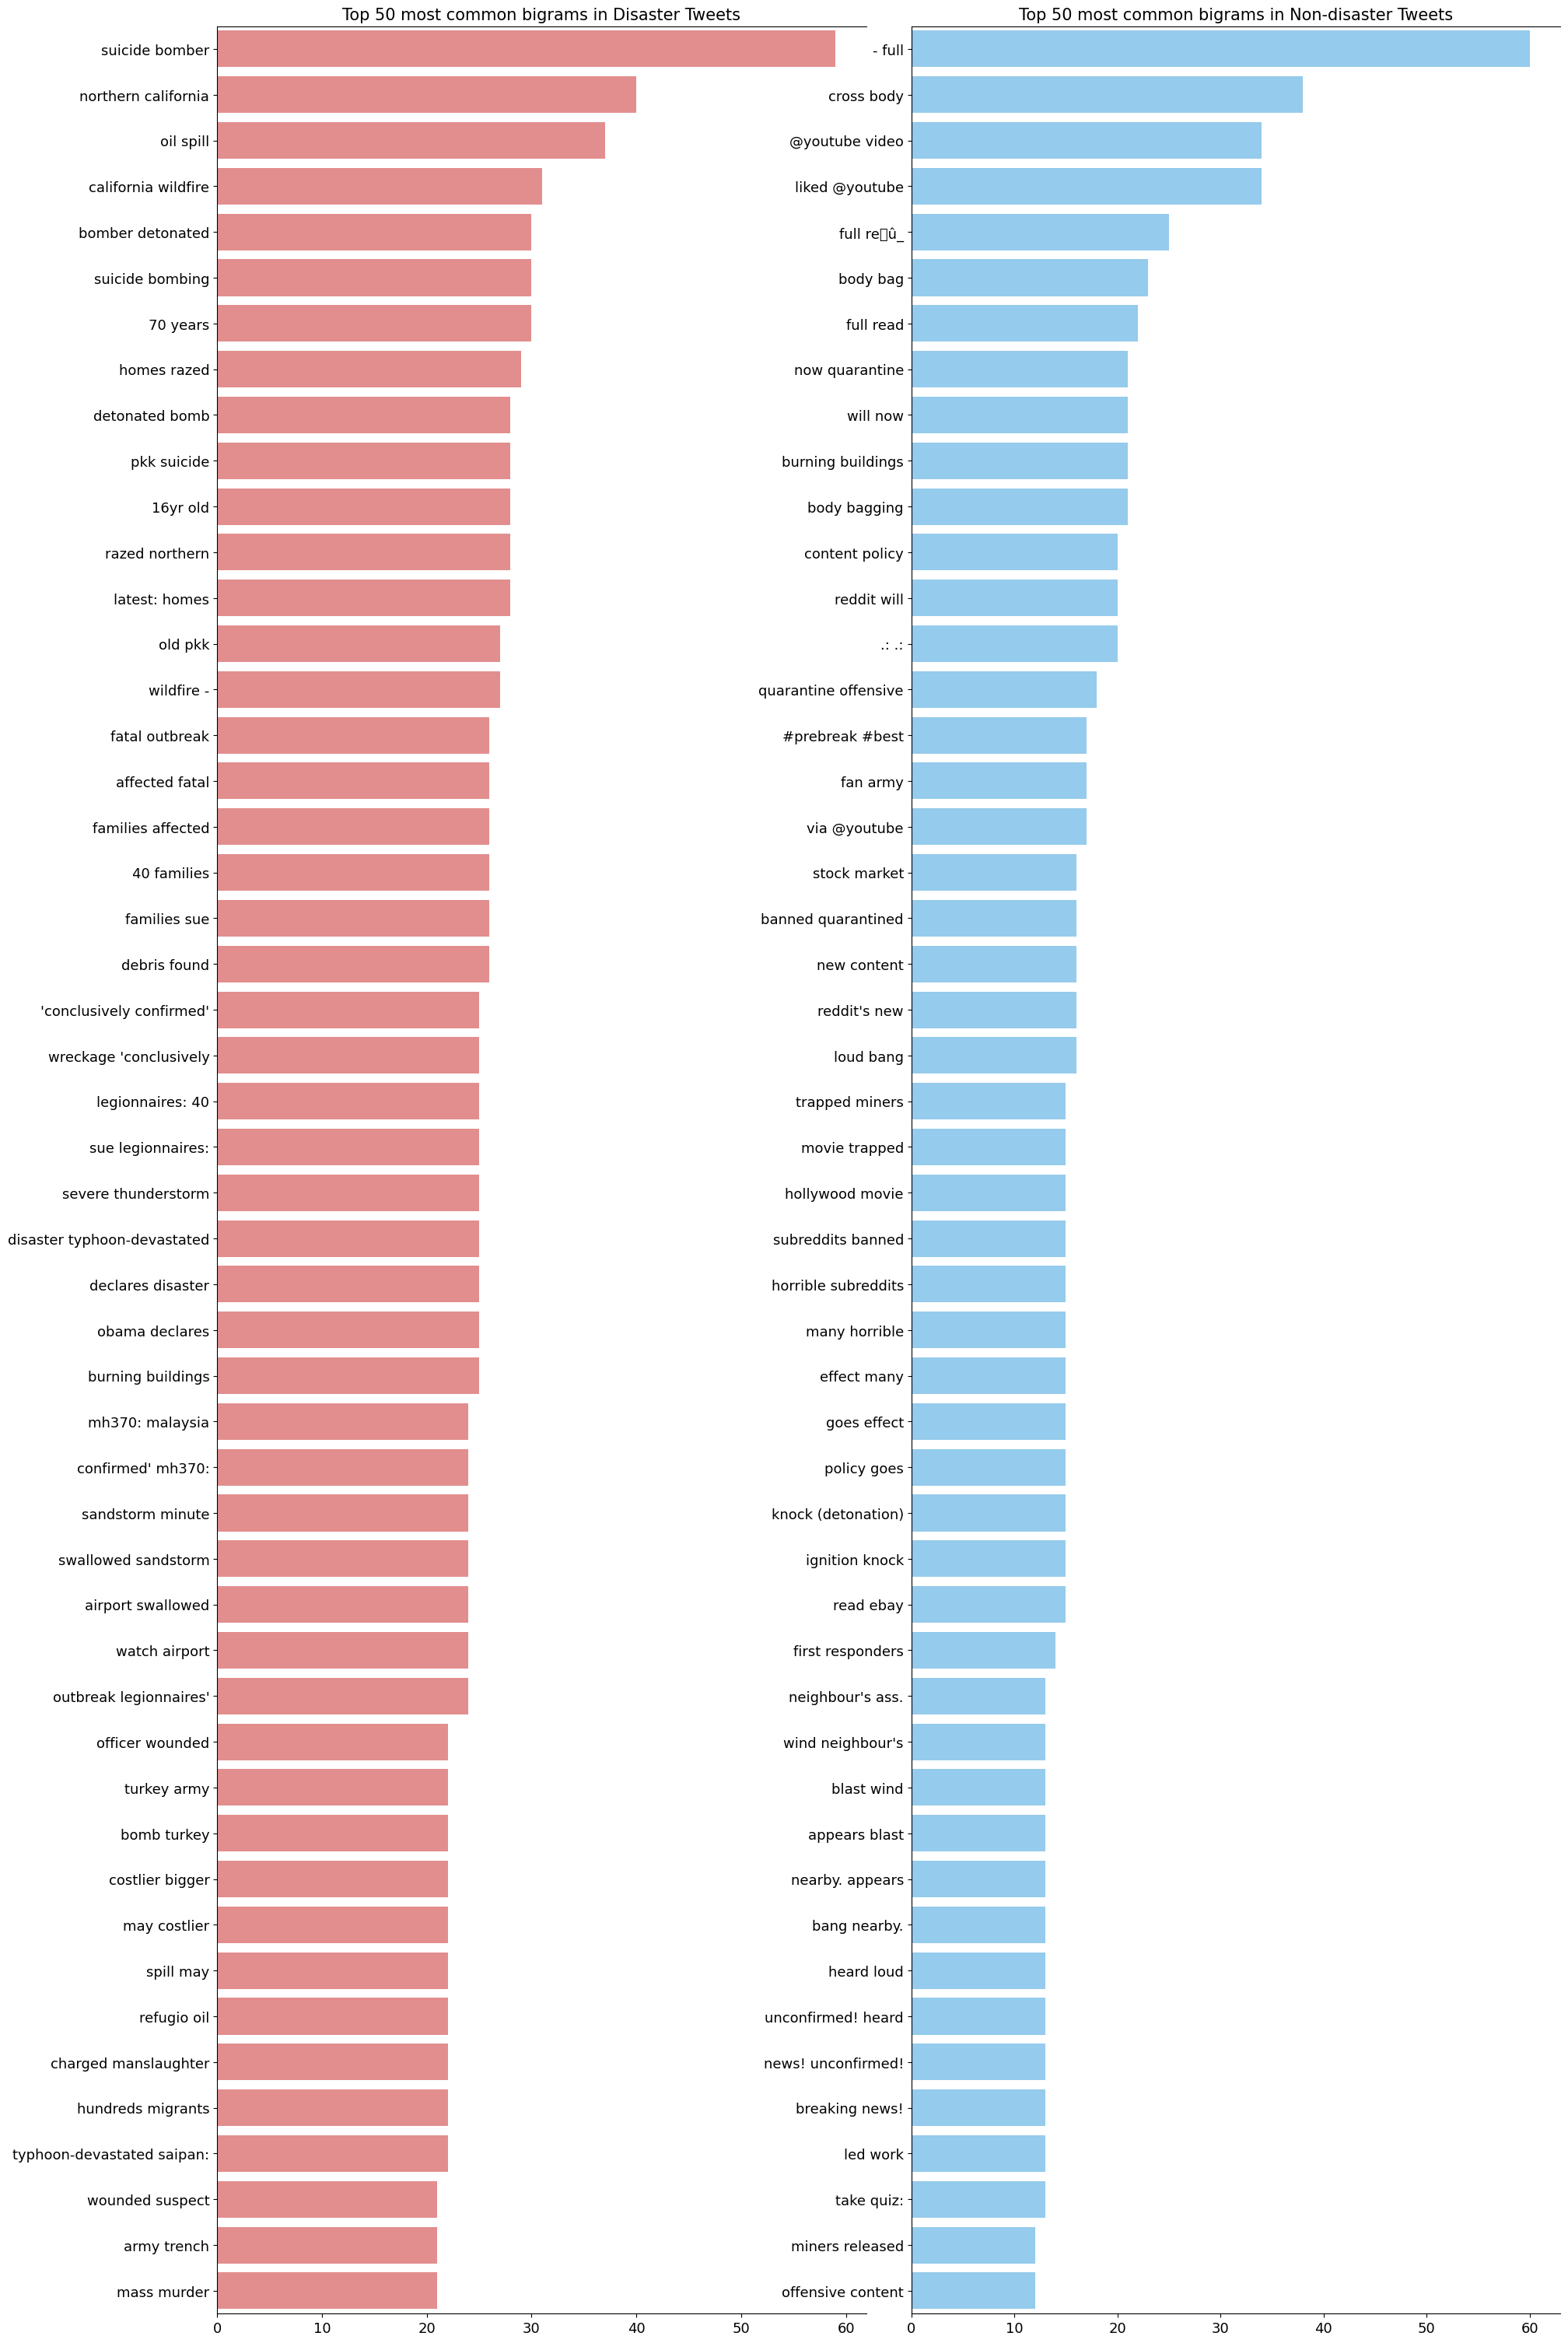

In [11]:
# Configura una figura con dos subplots (gráficos) para las visualizaciones.
fig, axes = plt.subplots(ncols=2, figsize=(18,30), dpi=100)
# Ajusta el layout para evitar superposiciones.
plt.tight_layout()

# Genera un gráfico de barras horizontales para los bigramas más comunes en tweets de desastres.
sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='lightcoral')
# Genera un gráfico de barras horizontales para los bigramas más comunes en tweets no desastres.
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='lightskyblue')

# Configura la visualización de los ejes y etiquetas.
for i in range(2):
    axes[i].spines['right'].set_visible(False) # Oculta el borde derecho para mejorar la estética.
    axes[i].set_xlabel('') # Elimina la etiqueta del eje x.
    axes[i].set_ylabel('') # Elimina la etiqueta del eje y.
    axes[i].tick_params(axis='x', labelsize=13) # Configura el tamaño de la etiqueta para el eje x.
    axes[i].tick_params(axis='y', labelsize=13) # Configura el tamaño de la etiqueta para el eje y.

# Configura los títulos de los gráficos.
axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

# Muestra los gráficos.
plt.show()

**Celda 12:** Visualización de Trigramas

**Descripción:** Esta celda visualiza los trigramas más comunes en ambos tipos de tweets. Al analizar trigramas, se pueden identificar frases específicas asociadas a cada categoría, lo que puede ser crucial para afinar modelos de NLP y entender mejor los patrones de comunicación en situaciones de desastre.

C:\Users\rgall\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


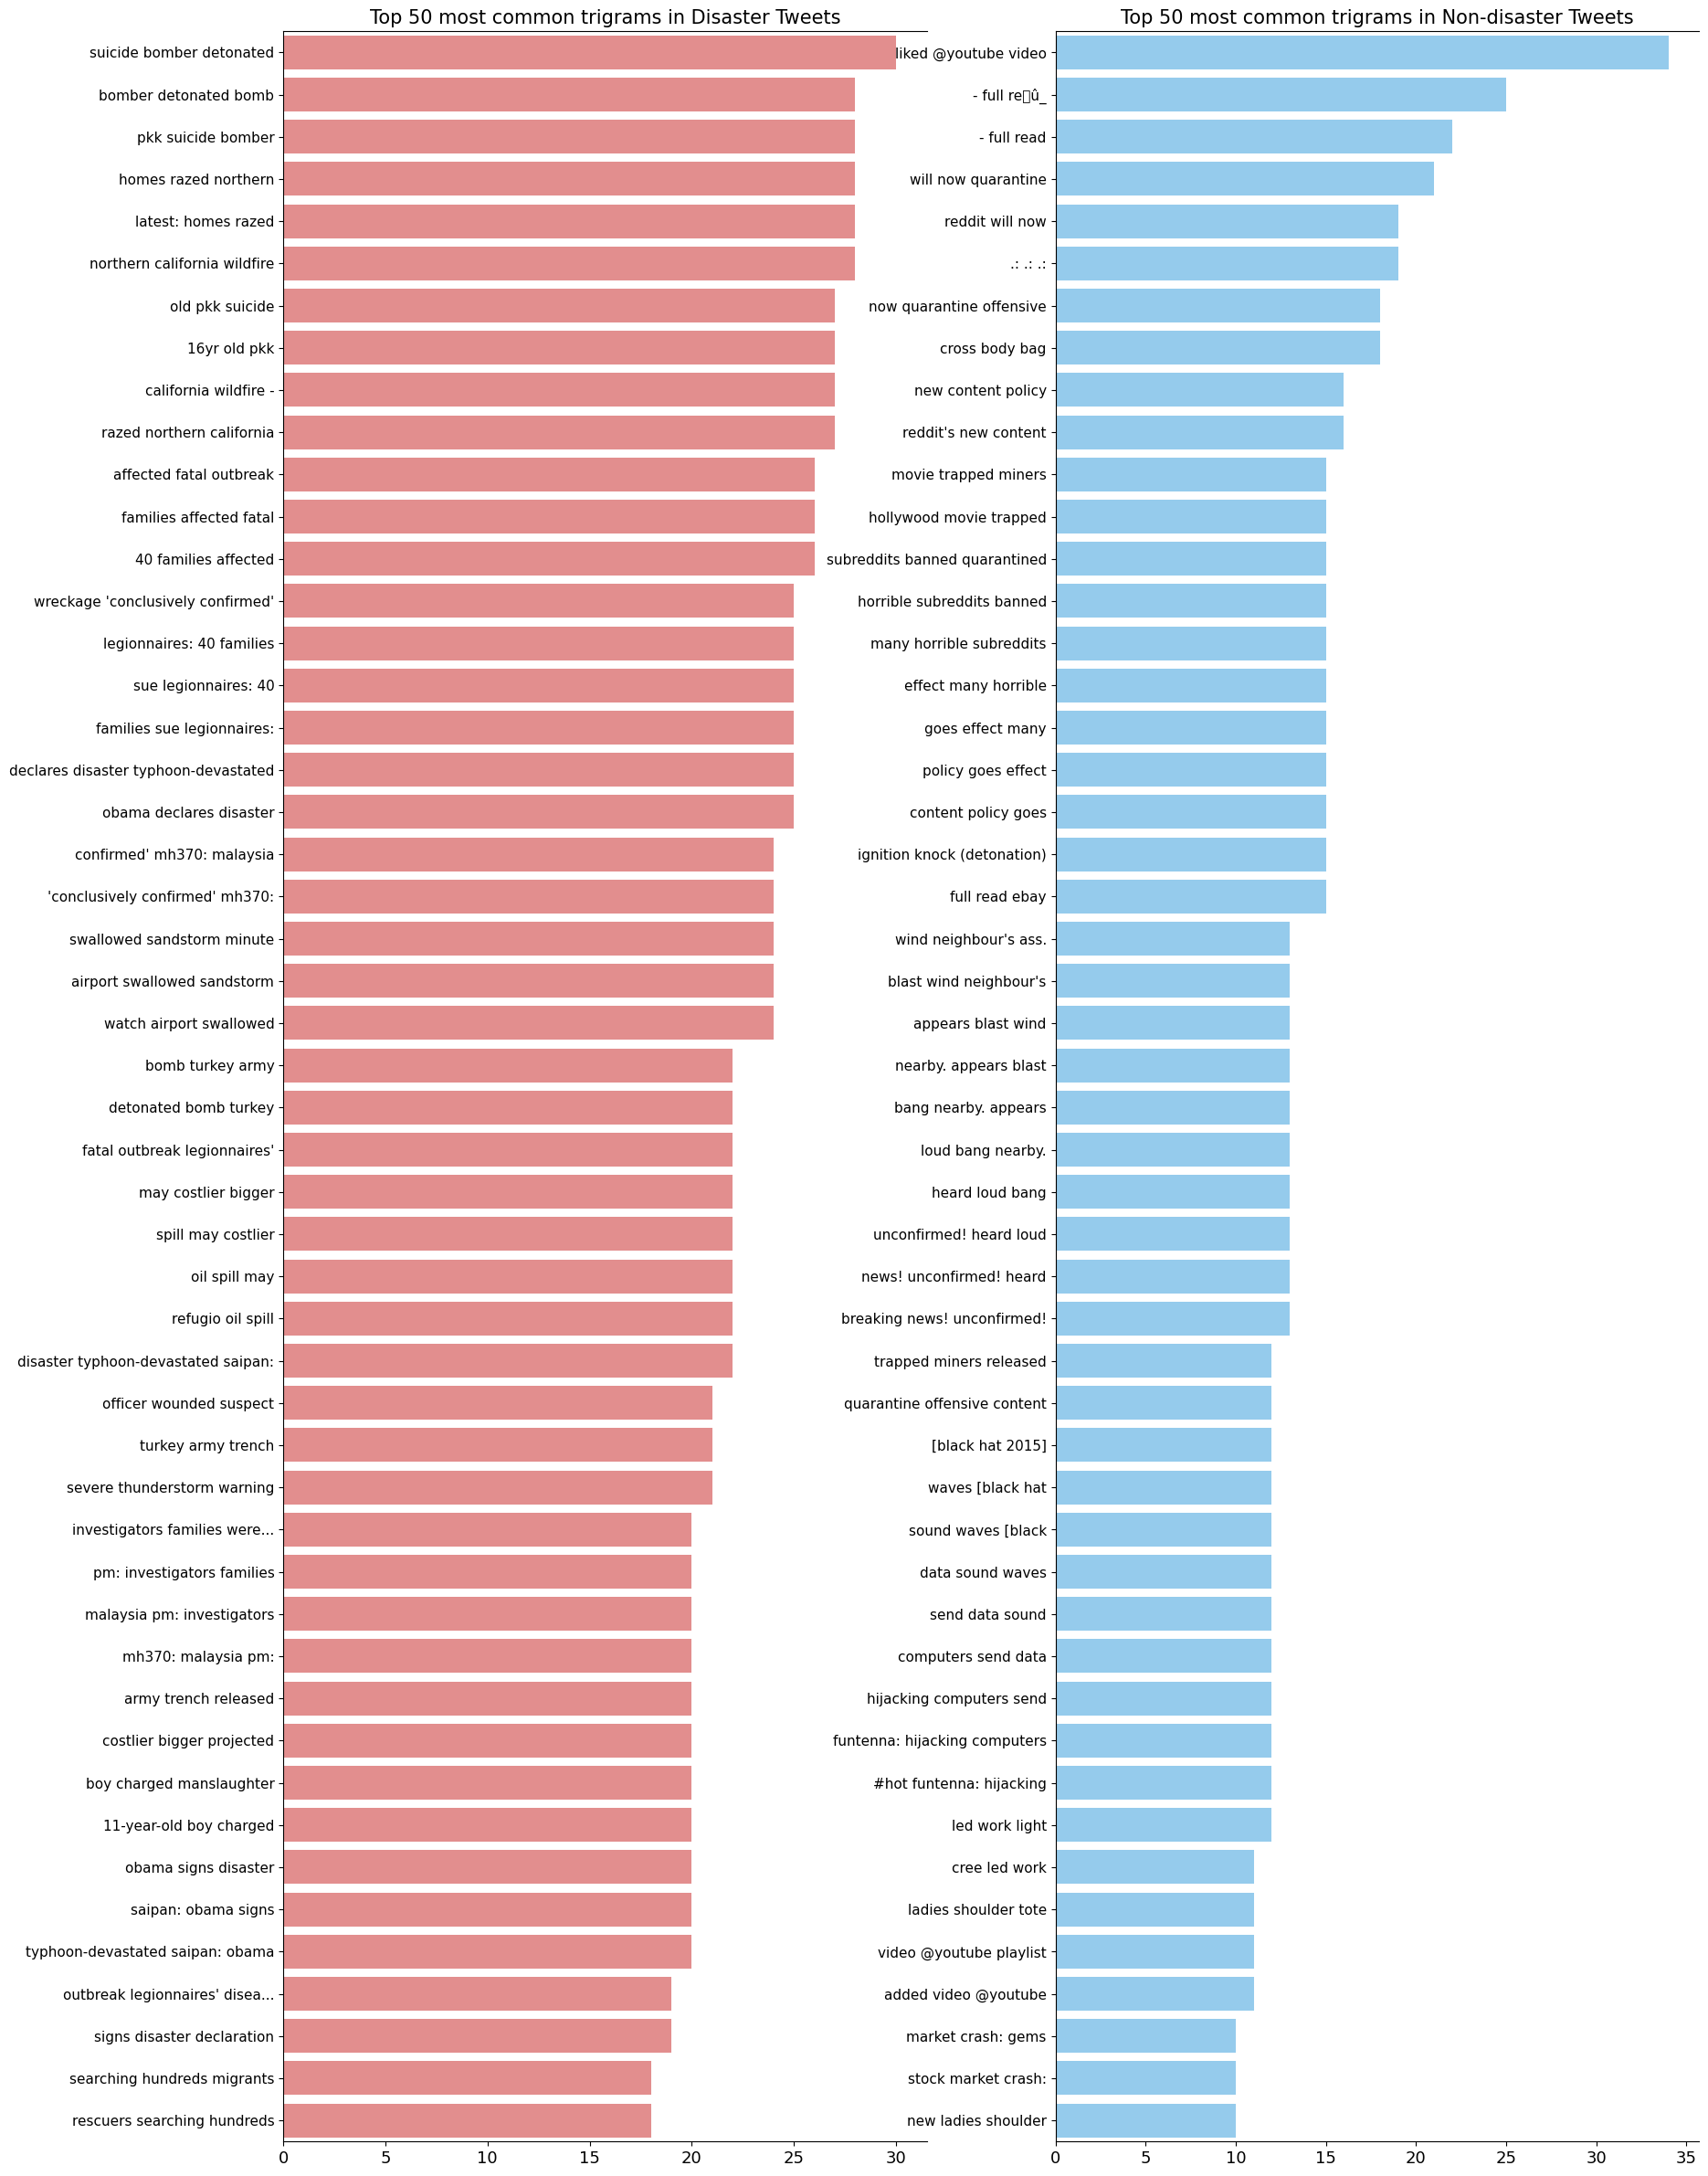

In [12]:
# Configura una figura con dos subplots (gráficos) para las visualizaciones.
fig, axes = plt.subplots(ncols=2, figsize=(20, 30), dpi=100)

# Genera un gráfico de barras horizontales para los trigramas más comunes en tweets de desastres.
sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color='lightcoral')
# Genera un gráfico de barras horizontales para los trigramas más comunes en tweets no desastres.
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color='lightskyblue')

# Configura la visualización de los ejes y etiquetas.
for i in range(2):
    axes[i].spines['right'].set_visible(False) # Oculta el borde derecho para mejorar la estética.
    axes[i].set_xlabel('') # Elimina la etiqueta del eje x.
    axes[i].set_ylabel('') # Elimina la etiqueta del eje y.
    axes[i].tick_params(axis='x', labelsize=13) # Configura el tamaño de la etiqueta para el eje x.
    axes[i].tick_params(axis='y', labelsize=11) # Configura el tamaño de la etiqueta para el eje y.

# Configura los títulos de los gráficos.
axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=15)

# Muestra los gráficos.
plt.show()

**Celda 13:** Geolocalización y Visualización en Mapa

**Descripción:** En esta celda, se utiliza geopy y folium para geolocalizar y visualizar en un mapa las 10 ubicaciones más frecuentes de tweets. Esto ofrece una perspectiva visual de las áreas geográficas desde donde se envían más tweets, proporcionando contexto adicional que puede ser relevante para análisis de desastres.

In [13]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium 
from folium import plugins 

# Crear un nuevo DataFrame para almacenar las ubicaciones y sus conteos.
new_df = pd.DataFrame()
new_df['location'] = ((train['location'].value_counts())[:10]).index  # Las 10 localizaciones más comunes.
new_df['count'] = ((train['location'].value_counts())[:10]).values # Conteos de esas localizaciones.

# Configura el geocodificador con un límite de tasa para evitar el bloqueo de la API.
geolocator = Nominatim(user_agent = 'Rahil')
geocode = RateLimiter(geolocator.geocode, min_delay_seconds = 0.5)

# Diccionarios para almacenar las latitudes y longitudes.
lat = {}
long = {}

# Geocodifica cada ubicación para obtener latitud y longitud.
for i in new_df['location']:
    location = geocode(i)
    lat[i] = location.latitude
    long[i] = location.longitude

# Añade las latitudes y longitudes al DataFrame.
new_df['latitude'] = new_df['location'].map(lat)
new_df['longitude'] = new_df['location'].map(long)

# Configura el mapa usando folium.
map = folium.Map(location = [10.0, 10.0], tiles = 'CartoDB dark_matter', zoom_start = 1.5)
markers = []
title = '''<h1 align = "center" style = "font-size: 15px"><b>Top 10 Tweet Locations</b></h1>'''

# Añade marcadores al mapa para cada ubicación.
for i, r in new_df.iterrows():
    loss = r['count']
    if r['count'] > 0:
        counts = r['count'] * 0.4
        folium.CircleMarker([float(r['latitude']), float(r['longitude'])], radius = float(counts), color = 'lightcoral', fill = True).add_to(map)

# Añade el título al mapa.
map.get_root().html.add_child(folium.Element(title))

# Muestra el mapa.
map

**Celda 14:** Identificación de Tweets Mislabeled

**Descripción:** Esta celda identifica tweets que tienen múltiples etiquetas ('target'), lo cual puede indicar errores en los datos o ambigüedad en cómo los tweets fueron clasificados. Esto es importante para la limpieza de datos y para asegurar la calidad del entrenamiento del modelo.

In [14]:
# Agrupar el dataframe 'train' por la columna 'text' y contar las frecuencias de cada grupo.
df_mislabeled = train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
# Filtrar los grupos donde el número de etiquetas únicas 'target' es mayor que 1, indicando posibles errores de etiquetado.
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
# Obtener la lista de índices de los tweets mal etiquetados
df_mislabeled.index.tolist()

['like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit',
 'Hellfire! We don\x89Ûªt even want to think about it or mention it so let\x89Ûªs not do anything that leads to it #islam!',
 "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'",
 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!',
 'To fight bioterrorism sir.',
 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE',
 '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption',
 '#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect',
 'He came to a land which was engulfed in tribal war and turned it into a land 

**Celda 15:** Limpieza de Datos

**Descripción:** Aquí se eliminan las columnas que se consideran no esenciales para el análisis o modelado posterior, simplificando el conjunto de datos y potencialmente mejorando el rendimiento del modelo al eliminar ruido o datos irrelevantes.

In [15]:
# Elimina las columnas 'id', 'keyword' y 'location' del DataFrame 'train'
train = train.drop(['id', 'keyword', 'location'], axis=1)

**Celda 16:** Visualización de Datos Después de la Limpieza

**Descripción:** Esta celda muestra las primeras cinco filas del conjunto de datos de entrenamiento después de realizar modificaciones en las celdas anteriores, como la eliminación de columnas. Es útil para verificar que los cambios se hayan aplicado correctamente y para obtener una vista rápida de los datos con los que se trabajará a continuación.

In [16]:
# Muestra las primeras filas del DataFrame para verificar que las columnas han sido eliminadas
train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


**Celda 17:** Cantidad de Filas en el Dataset

**Descripción:** Muestra la cantidad total de filas en el conjunto de datos de entrenamiento. Este es un paso de verificación simple para comprender el tamaño del conjunto de datos con el que se está trabajando, lo cual es importante para la planificación del procesamiento de datos y el análisis de rendimiento del modelo.

In [17]:
# Calcula y muestra el número de filas del DataFrame
len(train)

7613

**Celda 18:** Preparación de Corpus para Análisis

**Descripción:** Esta celda prepara un corpus de palabras a partir del texto de los tweets. Primero, restablece el índice del DataFrame, luego tokeniza cada tweet, convierte las palabras a minúsculas y las agrega a una lista. Esta preparación es fundamental para análisis de texto y NLP, permitiendo posteriores análisis de frecuencia y otros procesamientos lingüísticos.

In [18]:
from nltk import FreqDist
import nltk

# Restablece los índices del DataFrame 'train' y descarta el índice anterior
train.reset_index(drop=True)

# Tokeniza las oraciones y las convierte a minúsculas, añadiendo esos valores a la lista 'corpus'
corpus = []
for i in range(0, (len(train)-1)):
    # Obtiene la oración en la posición 'i' de la columna 'text' del DataFrame
    sentence = train['text'][i]
    # Tokeniza la oración en palabras
    tokens = nltk.wordpunct_tokenize(sentence)
    # Convierte cada palabra a minúsculas
    words = [w.lower() for w in tokens]
    # Añade la lista de palabras procesadas a 'corpus'
    corpus.append(words)

**Celda 19:** Aplanamiento de la Lista de Listas

**Descripción:** Aplana la lista de listas generada en la celda anterior en una única lista para facilitar el análisis. Muestra las primeras 10 palabras del corpus aplanado, proporcionando una verificación rápida del contenido del corpus y la efectividad del proceso de tokenización y limpieza.

In [19]:
# Importa la función 'flatten' del módulo 'pandas.core.common' para aplanar listas de listas
from pandas.core.common import flatten

# Aplana la lista de listas 'corpus' en una sola lista 'wc'
wc = list(flatten(corpus))

# Muestra los primeros 10 elementos de la lista 'wc' para verificar el resultado
wc[:10]

['our',
 'deeds',
 'are',
 'the',
 'reason',
 'of',
 'this',
 '#',
 'earthquake',
 'may']

**Celda 20:** Análisis de Frecuencia de Palabras

**Descripción:** Calcula y muestra la frecuencia total de todas las palabras (incluyendo puntuaciones) y el número de palabras únicas en el corpus. Utiliza FreqDist de NLTK para este análisis, que es útil para entender la diversidad y la densidad del vocabulario en los datos de texto. Esto puede informar decisiones sobre preprocesamiento adicional y técnicas de vectorización de texto.

In [20]:
# Calcula la distribución de frecuencia de las palabras en 'wc'
dist = FreqDist(wc)

# Inicializa la variable 'wordtotal' para contar el total de palabras incluyendo puntuaciones
wordtotal = 0

# Itera sobre cada palabra única en la distribución de frecuencia
for word in dist.keys():
    # Suma la frecuencia de cada palabra al total de palabras
    wordtotal = wordtotal + dist[word]

# Imprime el total de palabras incluyendo puntuaciones
print("total words with punctuations:", wordtotal)

# Imprime el número total de palabras únicas
print("total unique words           :", len(dist))

total words with punctuations: 167204
total unique words           : 21999


**Celda 21:** Eliminación de Puntuación

**Descripción:** Esta celda define y utiliza una función para crear una distribución de frecuencia de palabras que excluye signos de puntuación. La función alphaFreqDist utiliza una expresión regular para filtrar palabras que contienen caracteres no alfabéticos. Esto limpia el corpus de texto, facilitando análisis más precisos y eliminando ruido potencial en los datos.

In [21]:
# Importa el módulo 're' para trabajar con expresiones regulares
import re

# Define una función para calcular la distribución de frecuencia de palabras sin puntuaciones
def alphaFreqDist(words):
    adist = FreqDist()  # Inicializa una distribución de frecuencia vacía
    pattern = re.compile('.*[^a-z].*')  # Compila un patrón de regex para identificar palabras con caracteres no alfabéticos
    for word in words:
        if not pattern.match(word):  # Si la palabra no coincide con el patrón (es decir, solo contiene letras)
            adist[word] += 1  # Incrementa el contador para esa palabra en la distribución de frecuencia
    return adist

# Calcula la distribución de frecuencia para palabras sin puntuaciones
adist = alphaFreqDist(wc)

# Inicializa la variable 'wordtot' para contar el total de palabras sin puntuaciones
wordtot = 0

# Itera sobre cada palabra única en la distribución de frecuencia
for word in adist.keys():
    wordtot = wordtot + adist[word]  # Suma la frecuencia de cada palabra al total de palabras

# Imprime el total de palabras sin puntuaciones
print("total words without punctuations:", wordtot)

# Imprime el número total de palabras únicas sin puntuaciones
print("total unique words              :", len(adist))

total words without punctuations: 121064
total unique words              : 16160


**Celda 22:** Eliminación de Palabras Vacías (Stopwords)

**Descripción:** Esta celda remueve las palabras vacías del corpus de palabras (wc). Las palabras vacías suelen ser preposiciones, conjunciones, etc., que no aportan significado diferencial en el análisis de texto para NLP. Eliminar estas palabras puede mejorar el rendimiento de los modelos de clasificación al reducir la dimensionalidad y enfocarse en palabras más significativas.

In [22]:
# Importa el módulo 'stopwords' del corpus de NLTK
from nltk.corpus import stopwords

# Descarga la lista de stopwords (palabras vacías) del idioma inglés
nltk.download('stopwords')

# Filtra las palabras en 'wc', excluyendo las stopwords
without_stopwords_wc = [t for t in wc if not t in stopwords.words("english")]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rgall\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Celda 23:** Distribución de Frecuencia sin Stopwords

**Descripción:** Similar a la celda 21, pero en este caso, la función withoutStopwordsDist crea una distribución de frecuencia solo de palabras que no son stopwords y son completamente alfabéticas. Esto reduce aún más el corpus a términos potencialmente más relevantes para el análisis.

In [23]:
# Define una función para calcular la distribución de frecuencia de palabras sin puntuaciones
def withoutStopwordsDist(words):
    wdist = FreqDist()  # Inicializa una distribución de frecuencia vacía
    pattern = re.compile('.*[^a-z].*')  # Compila un patrón de regex para identificar palabras con caracteres no alfabéticos
    for word in words:
        if not pattern.match(word):  # Si la palabra no coincide con el patrón (es decir, solo contiene letras)
            wdist[word] += 1  # Incrementa el contador para esa palabra en la distribución de frecuencia
    return wdist

# Calcula la distribución de frecuencia para palabras sin stopwords y sin puntuaciones
wdist = withoutStopwordsDist(without_stopwords_wc)

# Crea una lista de las palabras únicas en la distribución de frecuencia
without_sw = list(wdist.keys())

# Inicializa la variable 'wordtotws' para contar el total de palabras sin stopwords
wordtotws = 0

# Itera sobre cada palabra única en la distribución de frecuencia
for word in wdist.keys():
    wordtotws = wordtotws + wdist[word]  # Suma la frecuencia de cada palabra al total de palabras

# Imprime el total de palabras sin stopwords
print("total words without stopwords   :", wordtotws)

# Imprime el número total de palabras únicas sin stopwords
print("total unique words              :", len(wdist))

total words without stopwords   : 77749
total unique words              : 16013


**Celda 24:** Lematización

**Descripción:** Esta celda aplica lematización al corpus, que es el proceso de convertir una palabra a su forma base o de diccionario. La lematización ayuda a consolidar variantes de una palabra en una sola representación, mejorando la generalización del modelo.

In [24]:
# Importa el lematizador de NLTK
from nltk.stem import WordNetLemmatizer

# Descarga el conjunto de datos 'wordnet' necesario para la lematización
nltk.download('wordnet')

# Inicializa el lematizador
lemmatizer = WordNetLemmatizer()

# Inicializa una lista vacía para almacenar las palabras lematizadas
lemmawords = []

# Itera sobre las palabras en 'without_stopwords_wc'
for w in range(1, len(without_stopwords_wc)):
    # Lematiza la palabra actual y la añade a la lista 'lemmawords'
    lemmaword = lemmatizer.lemmatize(without_stopwords_wc[w-1])
    lemmawords.append(lemmaword)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rgall\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Celda 25:** Distribución de Frecuencia de Palabras Lematizadas

**Descripción:** Crea y muestra una distribución de frecuencia para palabras lematizadas, excluyendo cualquier palabra con caracteres no alfabéticos. Esta celda finaliza el proceso de limpieza y preparación de texto, proporcionando un conjunto de datos textual depurado para análisis o modelado posterior.

In [25]:
# Define una función para calcular la distribución de frecuencia de palabras lematizadas sin puntuaciones
def lemmaDist(words):
    ldist = FreqDist()  # Inicializa una distribución de frecuencia vacía
    pattern = re.compile('.*[^a-z].*')  # Compila un patrón de regex para identificar palabras con caracteres no alfabéticos
    for word in words:
        if not pattern.match(word):  # Si la palabra no coincide con el patrón (es decir, solo contiene letras)
            ldist[word] += 1  # Incrementa el contador para esa palabra en la distribución de frecuencia
    return ldist

# Calcula la distribución de frecuencia para palabras lematizadas sin puntuaciones
ldist = lemmaDist(lemmawords)

# Inicializa la variable 'wordtotle' para contar el total de palabras lematizadas
wordtotle = 0

# Itera sobre cada palabra única en la distribución de frecuencia
for word in ldist.keys():
    wordtotle = wordtotle + ldist[word]  # Suma la frecuencia de cada palabra al total de palabras

# Imprime el total de palabras lematizadas
print("total words lemmatized:", wordtotle)

# Imprime el número total de palabras únicas lematizadas
print("total unique words    :", len(ldist))

total words lemmatized: 77749
total unique words    : 14791


**Celda 26:** Agregando Conteo de Palabras y Normalización

**Descripción:** Esta celda agrega una nueva columna al DataFrame train que cuenta el número de palabras en cada tweet. También convierte todo el texto a minúsculas para normalizar los datos. Esta información puede ser útil como una característica adicional para los modelos predictivos. Además muestra las primeras cinco filas del conjunto de datos de entrenamiento.

In [26]:
#adding words count to the dataset. this can be used as feture to increase model accuracy later
train['wordscount'] = train['text'].apply(lambda x:len(str(x).split())) 
train['text']= [w.lower() for w in train['text']]
train.head()

,text,target,wordscount
0,our deeds are the reason of this #earthquake m...,1,13
1,forest fire near la ronge sask. canada,1,7
2,all residents asked to 'shelter in place' are ...,1,22
3,"13,000 people receive #wildfires evacuation or...",1,8
4,just got sent this photo from ruby #alaska as ...,1,16


**Celda 27:** Máximo y Mínimo de Palabras por Tweet

**Descripción:** Imprime el número máximo y mínimo de palabras encontradas en los tweets del conjunto de datos. Esto es útil para entender la distribución de la longitud del contenido y puede influir en decisiones sobre preprocesamiento o en la elección de técnicas de vectorización.

In [27]:
print('maximum number of words in a sentence :',max(train['wordscount']))
print('minimum number of words in a sentence :',min(train['wordscount']))

maximum number of words in a sentence : 31
minimum number of words in a sentence : 1


**Celda 28:** Función para Remover Stopwords

**Descripción:** Define una función que elimina palabras vacías (stopwords) y puntuación de los textos. Esto puede ayudar a reducir el ruido en los datos y mejorar el rendimiento de los modelos de clasificación.

In [28]:
#this function removes stopwords from the reviews
import string
def stopwordremover(review):
    stop_words = stopwords.words('english')
    review = review.split()
    review = " ".join([word for word in review if not word in stop_words])
    review = review.translate(str.maketrans('', '', string.punctuation))
    return review

**Celda 29:** Aplicación de la Función de Limpieza y Nueva Columna de Conteo

**Descripción:** Aplica la función de eliminación de stopwords a la columna de texto del DataFrame y recalcula el conteo de palabras post-limpieza. También muestra el DataFrame para verificar los cambios. Además muestra las primeras cinco filas del conjunto de datos de entrenamiento.

In [29]:
#use apply function to remove stopwords from the dataframe column
train['text']= train['text'].apply(stopwordremover)
#after removing stop words then count the number of words in the review.
train['text']= [w.lower() for w in train['text']]
train['wordscount1'] = train['text'].apply(lambda x:len(str(x).split())) 
train.head()

,text,target,wordscount,wordscount1
0,deeds reason earthquake may allah forgive us,1,13,7
1,forest fire near la ronge sask canada,1,7,7
2,residents asked shelter place notified officer...,1,22,11
3,13000 people receive wildfires evacuation orde...,1,8,7
4,got sent photo ruby alaska smoke wildfires pou...,1,16,9


**Celda 30:** Nuevo Máximo y Mínimo de Palabras por Tweet

**Descripción:** Imprime el número máximo y mínimo de palabras en los tweets después de la limpieza, proporcionando una comparación con los valores anteriores para evaluar el impacto de la eliminación de stopwords.

In [30]:
print('maximum number of words in a sentence :',max(train['wordscount1']))
print('minimum number of words in a sentence :',min(train['wordscount1']))

maximum number of words in a sentence : 25
minimum number of words in a sentence : 1


**Celda 31:** Vectorización de Texto

**Descripción:** Esta celda introduce la preparación para modelar los datos utilizando solo las palabras en las revisiones. Aquí se importa CountVectorizer de scikit-learn, una herramienta que convierte una colección de documentos de texto en una matriz de recuento de tokens. Esto permite transformar el texto en un formato utilizable para el modelado con algoritmos de machine learning.

In [31]:
# Se importa CountVectorizer desde sklearn.
from sklearn.feature_extraction.text import CountVectorizer

**Celda 32:** Aplicación del Vectorizador al Texto

**Descripción:** En esta celda, se crea una instancia del CountVectorizer y se aplica al conjunto de datos mediante el método fit_transform a la columna 'text' del DataFrame train. Este método no solo aprende el vocabulario de los datos sino que también transforma los datos de texto en una matriz dispersa de características de token. La variable X resultante contiene la representación vectorizada del texto que será utilizada para entrenar los modelos de machine learning.

In [32]:
# Se crea una instancia de CountVectorizer.
vectorizer = CountVectorizer()

# Aplicar el vectorizador a la columna 'text' del DataFrame 'train'.
X = vectorizer.fit_transform(train['text'])

**Celda 33:** Extracción de la Variable Objetivo

**Descripción:** Esta celda extrae la columna 'target' del DataFrame train y la almacena en la variable y. Esta columna representa la variable objetivo que se utilizará en el modelado. En tareas de clasificación, y contiene las etiquetas o categorías de cada documento, que el modelo intentará predecir basándose en las características extraídas y vectorizadas almacenadas en X.

In [33]:
y=train['target']

**Celda 34:** Importación de Clasificadores y Herramientas de Evaluación

**Descripción:** Esta celda importa una variedad de clasificadores de la biblioteca scikit-learn y xgboost, junto con herramientas de evaluación de modelos. Estos clasificadores incluyen tanto métodos lineales (como la regresión logística y RidgeClassifier) como métodos basados en árboles (como RandomForest y GradientBoosting). Además, se importan métricas de evaluación como la precisión, el informe de clasificación, y herramientas para generar matrices de confusión y curvas ROC, que son esenciales para evaluar el rendimiento del modelo.

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC

#libraries for model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

**Celda 35:** División de Datos en Conjuntos de Entrenamiento y Prueba

**Descripción:** En esta celda se utiliza la función train_test_split de scikit-learn para dividir el conjunto de datos en partes de entrenamiento y prueba. El test_size=0.2 indica que el 20% del conjunto de datos se reservará para el conjunto de prueba, mientras que el 80% restante se utilizará para entrenar el modelo. El random_state=1234 asegura que la división sea reproducible, lo que es importante para la consistencia de los experimentos.

In [35]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

**Celda 36:** Verificación de las Dimensiones de los Conjuntos Divididos

**Descripción:** Esta celda imprime las dimensiones de los conjuntos de entrenamiento y prueba (X_train y X_test) para verificar la cantidad de muestras y características con las que se trabajarán. Este paso es una buena práctica para asegurarse de que los datos se hayan dividido correctamente y para entender el volumen de datos que el modelo utilizará durante el entrenamiento y las pruebas.

In [36]:
print(x_train.shape)
print(x_test.shape)

(6090, 22370)
(1523, 22370)


**Celda 37:** Entrenamiento y Evaluación del Random Forest

**Descripción:** Esta celda se enfoca en entrenar y evaluar un modelo de clasificación usando RandomForestClassifier de scikit-learn. El proceso incluye entrenar el modelo con los datos de entrenamiento, evaluar su precisión tanto en el conjunto de entrenamiento como en el de prueba, y luego usar el modelo para predecir resultados en el conjunto de prueba. Finalmente, se genera un reporte de clasificación y una matriz de confusión que proporcionan una visión detallada del rendimiento del modelo, incluyendo métricas clave como precisión, recall y el F1-score para las predicciones realizadas.

train accuracy: 0.997208538587849 
 test accuracy: 0.7951411687458962


classification report for random forest classifier
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       841
           1       0.87      0.64      0.74       682

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.78      1523
weighted avg       0.81      0.80      0.79      1523



confusion matrix for random forest classifier


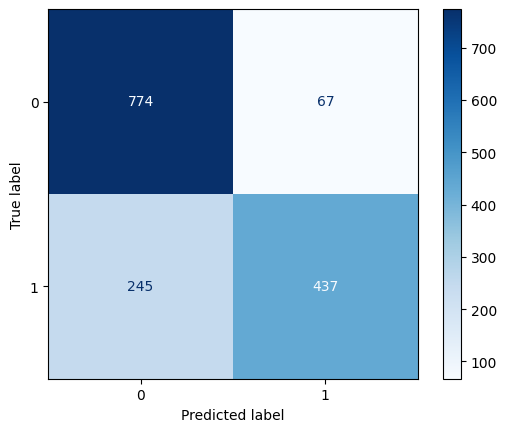

In [37]:
#random forest classifier
rf=RandomForestClassifier(random_state=1234)
model1=rf.fit(x_train, y_train)
print("train accuracy:",model1.score(x_train, y_train),"\n","test accuracy:",model1.score(x_test,y_test))

rfpred = rf.predict(x_test)
print("\n")
print("classification report for random forest classifier")
print(classification_report(y_test,rfpred))
print("\n")
print("confusion matrix for random forest classifier")
ConfusionMatrixDisplay.from_estimator(rf, x_test, y_test,cmap="Blues")

**Celda 38:** Entrenamiento y Evaluación del Perceptron

**Descripción:** Esta celda se enfoca en entrenar y evaluar un modelo de clasificación usando Perceptron de scikit-learn. El proceso incluye entrenar el modelo con los datos de entrenamiento, evaluar su precisión tanto en el conjunto de entrenamiento como en el de prueba, y luego usar el modelo para predecir resultados en el conjunto de prueba. Finalmente, se genera un reporte de clasificación y una matriz de confusión que proporcionan una visión detallada del rendimiento del modelo, incluyendo métricas clave como precisión, recall y el F1-score para las predicciones realizadas.

train accuracy: 0.9947454844006568 
 test accuracy: 0.7754432042022325


classification report for perceptron classifier
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       841
           1       0.76      0.73      0.74       682

    accuracy                           0.78      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.77      0.78      0.77      1523



confusion matrix for perceptron classifier


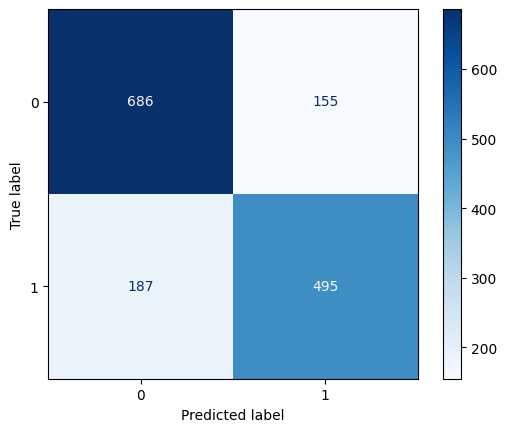

In [38]:
from sklearn.linear_model import Perceptron

#perceptron classifier
pt = Perceptron(max_iter=1000, tol=1e-3, random_state=1234)
model2=pt.fit(x_train, y_train)
print("train accuracy:",model2.score(x_train, y_train),"\n","test accuracy:",model2.score(x_test,y_test))

ptpred = pt.predict(x_test)
print("\n")
print("classification report for perceptron classifier")
print(classification_report(y_test,ptpred))
print("\n")
print("confusion matrix for perceptron classifier")
ConfusionMatrixDisplay.from_estimator(pt, x_test, y_test,cmap="Blues")

**Celda 39:** Uso de TF-IDF para la Vectorización de Texto


**Descripción:** Se importa y crea una instancia de TfidfVectorizer para transformar el texto en una matriz de características TF-IDF. A diferencia de CountVectorizer, este método evalúa no solo la frecuencia de las palabras, sino que también toma en cuenta la importancia de las palabras en los documentos del conjunto de datos (ponderación TF-IDF).

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

#getting tfidf vlaues for feedback
vectorizertf = TfidfVectorizer()
Xt = vectorizertf.fit_transform(train['text'])

**Celda 40:** División de Datos en Conjuntos de Entrenamiento y Prueba

**Descripción:** Utiliza train_test_split para dividir los datos en conjuntos de entrenamiento y prueba. El 20% de los datos se usa para el conjunto de prueba, y el 80% restante para entrenamiento, con un estado aleatorio fijo para reproducibilidad.

In [40]:
#dividing the dataset to train and test 
xtrain, xtest, ytrain, ytest = train_test_split(Xt, y, test_size=0.2, random_state=1234)

**Celda 41:** Entrenamiento y Evaluación del RandomForest Classifier

**Descripción:** Esta celda se enfoca en entrenar y evaluar un modelo de clasificación usando RandomForestClassifier de scikit-learn. El proceso incluye entrenar el modelo con los datos de entrenamiento, evaluar su precisión tanto en el conjunto de entrenamiento como en el de prueba, y luego usar el modelo para predecir resultados en el conjunto de prueba. Finalmente, se genera un reporte de clasificación y una matriz de confusión que proporcionan una visión detallada del rendimiento del modelo, incluyendo métricas clave como precisión, recall y el F1-score para las predicciones realizadas.

train accuracy: 0.997208538587849 
 test accuracy: 0.7951411687458962


classification report for random forest classifier
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       841
           1       0.87      0.64      0.74       682

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.78      1523
weighted avg       0.81      0.80      0.79      1523



confusion matrix for random forest classifier


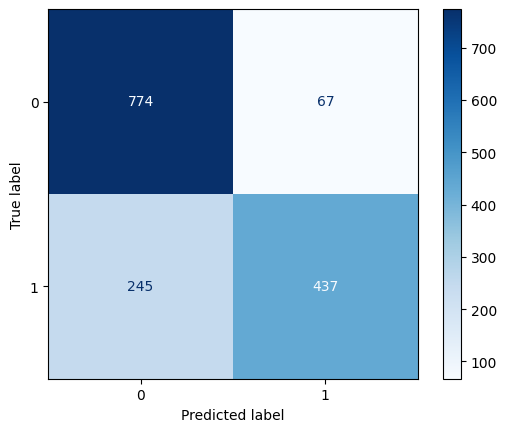

In [41]:
#random forest classifier
rf=RandomForestClassifier(random_state=1234)
model1=rf.fit(x_train, y_train)
print("train accuracy:",model1.score(x_train, y_train),"\n","test accuracy:",model1.score(x_test,y_test))

rfpred = rf.predict(x_test)
print("\n")
print("classification report for random forest classifier")
print(classification_report(y_test,rfpred))
print("\n")
print("confusion matrix for random forest classifier")
ConfusionMatrixDisplay.from_estimator(rf, x_test, y_test,cmap="Blues")

**Celda 42:** Entrenamiento y Evaluación del Perceptron

**Descripción:** Esta celda se enfoca en entrenar y evaluar un modelo de clasificación usando Perceptron de scikit-learn. El proceso incluye entrenar el modelo con los datos de entrenamiento, evaluar su precisión tanto en el conjunto de entrenamiento como en el de prueba, y luego usar el modelo para predecir resultados en el conjunto de prueba. Finalmente, se genera un reporte de clasificación y una matriz de confusión que proporcionan una visión detallada del rendimiento del modelo, incluyendo métricas clave como precisión, recall y el F1-score para las predicciones realizadas.

train accuracy: 0.9947454844006568 
 test accuracy: 0.7754432042022325


classification report for perceptron classifier
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       841
           1       0.76      0.73      0.74       682

    accuracy                           0.78      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.77      0.78      0.77      1523



confusion matrix for perceptron classifier


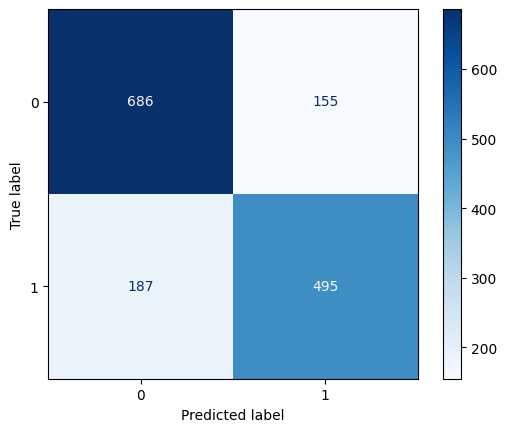

In [42]:
#perceptron classifier
pt = Perceptron(max_iter=1000, tol=1e-3, random_state=1234)
model2=pt.fit(x_train, y_train)
print("train accuracy:",model2.score(x_train, y_train),"\n","test accuracy:",model2.score(x_test,y_test))

ptpred = pt.predict(x_test)
print("\n")
print("classification report for perceptron classifier")
print(classification_report(y_test,ptpred))
print("\n")
print("confusion matrix for perceptron classifier")
ConfusionMatrixDisplay.from_estimator(pt, x_test, y_test,cmap="Blues")